# COVID Modeling 

In [193]:
# data handling
import pandas as pd
import numpy as np

# seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [194]:
train = pd.read_csv('../data/training_data.csv', index_col="Unnamed: 0")
train['Date'] = pd.to_datetime(train['Date'])
val = pd.read_csv('../data/validation_data.csv', index_col="Unnamed: 0")
test = pd.read_csv('../data/testing_data.csv', index_col="Unnamed: 0")

In [195]:
train.columns

Index(['Date', 'State', 'Total Pop', 'Day_of_Wk', 'Confirmed',
       'Confirmed_diff', 'Confirmed_rate', 'Confirmed_rate_diff', 'Deaths',
       'Deaths_diff', 'Deaths_rate', 'Deaths_rate_diff', 'Recovered',
       'Recovered_rate', 'Recovered_diff', 'Recovered_rate_diff', 'Active',
       'Active_diff', 'Active_rate_diff', 'Active_rate', 'Case_Fatality_Ratio',
       'Administered', 'Series_Complete_Yes', 'Month', 'Year',
       'Monthly Temp (F)', 'Monthly Avg Temp (F)'],
      dtype='object')

In [196]:
train.head()

,Date,State,Total Pop,Day_of_Wk,Confirmed,Confirmed_diff,Confirmed_rate,Confirmed_rate_diff,Deaths,Deaths_diff,...,Active_diff,Active_rate_diff,Active_rate,Case_Fatality_Ratio,Administered,Series_Complete_Yes,Month,Year,Monthly Temp (F),Monthly Avg Temp (F)
0,2020-04-12,Alabama,4903185,Sunday,3667,NaN,0.000748,NaN,93,NaN,...,NaN,NaN,0.000708,2.610160,0.0,0.0,4,2020,61.55,63.096875
1,2020-04-13,Alabama,4903185,Monday,3870,203.0,0.000789,0.000041,99,6.0,...,165.0,0.000034,0.000741,2.651312,0.0,0.0,4,2020,61.55,63.096875
2,2020-04-14,Alabama,4903185,Tuesday,4041,171.0,0.000824,0.000035,114,15.0,...,204.0,0.000042,0.000783,2.883886,0.0,0.0,4,2020,61.55,63.096875
3,2020-04-15,Alabama,4903185,Wednesday,4307,266.0,0.000878,0.000054,118,4.0,...,118.0,0.000024,0.000807,2.895706,0.0,0.0,4,2020,61.55,63.096875
4,2020-04-16,Alabama,4903185,Thursday,4465,158.0,0.000911,0.000032,133,15.0,...,255.0,0.000052,0.000859,3.060990,0.0,0.0,4,2020,61.55,63.096875


## Modeling Methods and Metrics

In [334]:
metrics = ['RSME','Rolling RSME']
datasets = ["Training", "Validation"]

def RSME(model, X, Y):
    Y_pred = model.predict(X)
    RSME = np.sqrt(np.mean((Y_pred - Y)**2))[0]
    #rolling_RSME = 0 
    #return (RSME, rolling_RSME)
    return RSME

def RSME_df(df, pred_col, y_col): 
    '''
    df has two columns, one with predictions and one with actual values 
    Returns the RSME of the predictions w.r.t the actual values 
    '''
    diff = df[pred_col] - df[y_col]
    return np.sqrt(np.mean(diff**2))

def compute_RSME_by_state(model, X, Y):
    '''
    Y must have 'State' in the index 
    '''
    output_name = Y.columns


def compute_model_stats(model, X_train, Y_train, X_val, Y_val):
    model_stats = {}
    train_metrics = compute_stats(model, X_train, Y_train)
    model_stats['training'] = dict(zip(metrics, train_metrics))
    val_metrics = compute_stats(model, X_val, Y_val)
    model_stats['validation'] =  dict(zip(metrics, val_metrics))
    return model_stats
    
def print_model_stats(model_stats):
    print("Model Statistics:")
    print('                | ',' | '.join(list(model_stats.keys()), ))
    print('-----------------------------------------')
    for var in model_stats['training'].keys():
        print("{var:<15} |   {train:.3f}   |   {val:.3f}".format(var = var,
                                      train = model_stats['training'][var], 
                                      val   = model_stats['validation'][var]))


In [293]:
iterables = [datasets, metrics]
col_idx = pd.MultiIndex.from_product(iterables, names=["", ""])
    
def make_fresh_record():
    record = pd.DataFrame(columns=col_idx)
    record.index.name = "Model"
    return record 

def record_model_stats(record, model_stats, model_name, override=False): 
    model_stats_df = pd.json_normalize(model_stats, sep='_')
    model_stats_df.columns = col_idx
    model_data = model_stats_df.iloc[0]
    model_data.name = model_name
    new_record = record.copy()
    # override or new entry
    if override or model_name not in record.index:
        new_record.loc[model_name,:] = model_data
    #exists and don't overide 
    else:
        print("Warning: A model with the name '{}' already exists in this record.".format(model_name))
        print("         Either change model_name or set 'override=True'.")
        return record
    return new_record

### COVID Cases Modeling



In [294]:
def relabel_timeseries_data(X, Y, W, col_name="input"):
    timeseries_names = [col_name+'_day_'+str(i) for i in range(1-W,1)]

    target_day = Y.name
    Y.name = 'target_'+col_name
    Y = Y.reset_index()
    X = X.set_axis(timeseries_names, axis=1, inplace=False)
    X['Target_day'] = target_day
    Y['Target_day'] = target_day
    X = X.reset_index()
    X = X.set_index(['Target_day','State'])
    Y = Y.set_index(['Target_day','State'])
    return (X, Y)

def create_timeseries(df, col):
    return df.pivot_table(index = 'State', columns='Date',
                   values=col).sort_values(by = 'Date', axis='columns')


def convert_timeseries_to_data(df, W, col_name='input'):
    '''
    df is a dataframe, with columns sorted in increasing order by date
    splits rows into timeseries data with W columns of 'input' associated 
    with the W+1 column of 'output' and combined for all rows 
    '''
    d = df.shape[1]
    X = df.iloc[:, 0:W]
    Y = df.iloc[:,W]
    X, Y = relabel_timeseries_data(X, Y, W, col_name)

    for i in range(1,d-W):#1,3,..., d-W-1
        X_data = df.iloc[:, i:i+W] # i+W-1 = W+1,W+2,... d-1
        Y_data = df.iloc[:,i+W] # i+W = W+2,W+3,..., W+d-W = d
        X_data, Y_data = relabel_timeseries_data(X_data, Y_data, W, col_name)
        X = X.append(X_data)
        Y = Y.append(Y_data)

    return (X, Y)

### Model 1 

Feed in confirmed cases for the previous 14 days (since 2 weeks is a standard COVID incubation period) and predict confirmed cases. 

In [295]:
from sklearn.linear_model import LinearRegression

def model_1_pipeline(data, test_data=False): 
    window_size = 14
    timeseries_data = create_timeseries(data,'Confirmed_diff')
    X_data, Y_data  = convert_timeseries_to_data(timeseries_data, 
                                                window_size, 
                                                col_name="Confirmed_diff")
    if test_data:
        return X_data
    else: 
        return (X_data, Y_data)

    
def model_1_processing(train, val):
    model = LinearRegression()
    X_train, Y_train = model_1_pipeline(train)
    X_val, Y_val = model_1_pipeline(val)
    model.fit(X_train, Y_train)
    return model 

In [297]:
model1 = model_1_processing(train, val)
X_train, Y_train = model_1_pipeline(train)
X_val, Y_val = model_1_pipeline(val)
RSME, _ = compute_stats(model1, X_train, Y_train)
RSME

848.1276994348364

In [344]:
Y_train
X_train_pred = pd.DataFrame(data=model1.predict(X_train), index=Y_train.index, columns=Y_train.columns)
both_data = X_train_pred.merge(Y_train, left_index=True, right_index=True, suffixes=('_pred','_actual'))
cols = both_data.columns
state_pred = both_data.reset_index()[['State']+list(cols)].groupby('State').agg(RSME_df, pred_col = 'target_Confirmed_diff_pred', y_col='target_Confirmed_diff_actual')
state_pred = state_pred
state_pred

State
Alabama                  422.045502
Arizona                  599.190433
Arkansas                 246.570413
California              1857.124956
Colorado                 352.517907
Connecticut              531.161941
Delaware                  81.941154
District of Columbia      59.708001
Florida                 1578.107413
Georgia                 2264.771108
Idaho                    220.302144
Illinois                 982.502107
Indiana                  413.936126
Iowa                     468.683289
Kansas                  1528.136479
Kentucky                 406.511350
Louisiana                774.214854
Maine                     51.144105
Maryland                 225.557218
Massachusetts            743.092953
Michigan                1467.047454
Minnesota                726.865128
Mississippi              279.034695
Missouri                 741.981102
Montana                  128.059704
Nebraska                 384.546434
Nevada                   248.954156
New Hampshire         

In [333]:
RSME_df(both_data[cols])

TypeError: RSME_df() missing 2 required positional arguments: 'pred_col' and 'y_col'

In [ ]:
X_train_pred = pd.DataFrame(data=model1.predict(X_train), index=Y_train.index, columns=Y_train.columns)

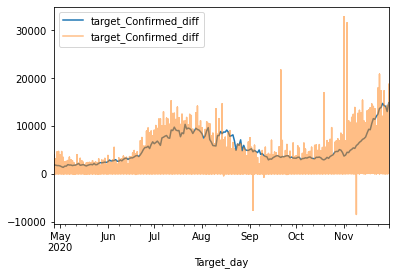

In [278]:
predictions_by_date_CA = X_train_pred.loc[(slice(None), "California"), :].reset_index().drop(columns='State')
ax1 = predictions_by_date_CA.plot(x='Target_day',y='target_Confirmed_diff');

Y_train.reset_index().drop(columns='State').plot(x='Target_day',y='target_Confirmed_diff', ax=ax1, alpha=0.5);


In [272]:
temp = Y_train.reset_index().drop(columns='State').merge(predictions_by_date_CA, on='Target_day', suffixes=('_actual','_pred'))
temp['diff'] = 

,Target_day,target_Confirmed_rate_diff_actual,target_Confirmed_rate_diff_pred
0,2020-04-27,0.000030,0.000063
1,2020-04-27,0.000026,0.000063
2,2020-04-27,0.000023,0.000063
3,2020-04-27,0.000038,0.000063
4,2020-04-27,0.000076,0.000063
...,...,...,...
10677,2020-11-30,0.000222,0.000405
10678,2020-11-30,0.000323,0.000405
10679,2020-11-30,0.000472,0.000405
10680,2020-11-30,0.000460,0.000405


In [279]:
np.mean((model1.predict(X_train) - Y_train)**2)

target_Confirmed_diff    719320.594549
dtype: float64